In [1]:
import os
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import zscore
from matplotlib import cm
from PIL import ImageColor
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA
from scipy.signal import argrelextrema
from matplotlib.pyplot import rcParams
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

rcParams.update({'font.family':'Arial', 'font.size': 16})

In [2]:
def find_minima_in_distribution(gene_values,overall_range,minima_range,accuracy):
    
    density = gaussian_kde(gene_values)
    
    data = []
    
    for i in range(int(overall_range[0]*accuracy),int(overall_range[1]*accuracy)+1):
        data.append(density(i/accuracy)[0])
        
    lb_index = int(abs((overall_range[0]*accuracy)-(minima_range[0]*accuracy)))
    len_minima_range = int((minima_range[1]-minima_range[0])*accuracy)
    
    minima_index = argrelextrema(np.array(data[lb_index:lb_index+len_minima_range]), np.less)
    
    if len(minima_index[0]) == 0:
        return None
    else:
        threshold_value = ((minima_index[0]/accuracy)+minima_range[0])[0]
        #print(overall_range,minima_range,overall_range[0]*accuracy,(overall_range[1]*accuracy)+1,lb_index,lb_index+len_minima_range,data[lb_index],data[lb_index+len_minima_range])
        return threshold_value

In [3]:
replicate_number = "r1"

list_genes = ['Slug','miR200','Zeb1','Cdh1','ERa66','ERa36','np63','Gata3','Foxa1','Pgr',"Nrf2"]

# base circuit
df_base = pd.read_csv("./circuit_4_signals_notch/"+replicate_number+"/core_solution.dat", sep = "\t", header = None)
df_base.columns =  ["parameter" ,"stability", "number"] + list_genes
df_base = df_base[df_base["stability"] <= 6]

# perturbed circuit
df = pd.read_csv("./circuit_4_signals_notch_OE/"+replicate_number+"/core_OE_14_solution.dat", sep = "\t", header = None)
df.columns = ["parameter" ,"stability", "number"]+list_genes
df = df[df["stability"] <= 6]

for col in list_genes:
    col_zscore = col + '_zscore'
    df_base[col_zscore] = (df_base[col] - df_base[col].mean())/df_base[col].std(ddof=0)
    
for col in list_genes:
    col_zscore = col + '_zscore'
    df[col_zscore] = (df[col] - df_base[col].mean())/df_base[col].std(ddof=0)
    
df_zscores_base = df_base[[i+"_zscore" for i in list_genes]]
df_zscores_pert = df[[i+"_zscore" for i in list_genes]]

df_scores_base = pd.DataFrame([])
Epithelial = df_zscores_base["miR200_zscore"] + df_zscores_base["Cdh1_zscore"]
Mesenchymal = df_zscores_base["Zeb1_zscore"] + df_zscores_base["Slug_zscore"]
EMT_score = Mesenchymal - Epithelial
Res_score = df_zscores_base["ERa36_zscore"] - df_zscores_base["ERa66_zscore"]
Luminal =  df_zscores_base["ERa66_zscore"] + df_zscores_base["Gata3_zscore"] + df_zscores_base["Foxa1_zscore"]  + df_zscores_base["Pgr_zscore"]
Basal = df_zscores_base["np63_zscore"] + df_zscores_base["Slug_zscore"]
LBT_score = Basal - Luminal
pEMT = Mesenchymal + Epithelial  - abs(EMT_score)
df_scores_base["LBT"] = LBT_score
df_scores_base["EMT"] = EMT_score

df_scores_pert = pd.DataFrame([])
Epithelial_pert = df_zscores_pert["miR200_zscore"] + df_zscores_pert["Cdh1_zscore"]
Mesenchymal_pert = df_zscores_pert["Zeb1_zscore"] + df_zscores_pert["Slug_zscore"]
EMT_score_pert = Mesenchymal_pert - Epithelial_pert
Res_score_pert = df_zscores_pert["ERa36_zscore"] - df_zscores_pert["ERa66_zscore"]
Luminal_pert =  df_zscores_pert["ERa66_zscore"] + df_zscores_pert["Gata3_zscore"] + df_zscores_pert["Foxa1_zscore"]  + df_zscores_pert["Pgr_zscore"]
Basal_pert = df_zscores_pert["np63_zscore"] + df_zscores_pert["Slug_zscore"]
LBT_score_pert = Basal_pert - Luminal_pert
pEMT_pert = Mesenchymal_pert + Epithelial_pert  - abs(EMT_score_pert)
df_scores_pert["LBT"] = LBT_score_pert
df_scores_pert["EMT"] = EMT_score_pert

lum_bas_threshold = -3.3230000000000004
df_luminal_base = df_scores_base[df_scores_base["LBT"] < lum_bas_threshold]
df_basal_base = df_scores_base[df_scores_base["LBT"] >= lum_bas_threshold]
df_luminal_pert = df_scores_pert[df_scores_pert["LBT"] < lum_bas_threshold]
df_basal_pert = df_scores_pert[df_scores_pert["LBT"] >= lum_bas_threshold]

pemt_epi_threshold = -0.6240000000000006
pemt_mes_threshold = 2.397
pemt_threshold_luminal = -1.6839999999999993

color_by = "pEMT"

#plt.scatter(list(EMT_score), list(LBT_score), s = 0.5, c=df_zscores_base["Nrf2_zscore"], cmap="RdBu_r")
plt.scatter(list(EMT_score), list(LBT_score), s = 0.5 , c='black')
#sns.kdeplot(x=list(EMT_score), y=list(LBT_score) , c='black')
plt.axhline(y=lum_bas_threshold, color='r', linestyle='--')
plt.vlines(x=pemt_epi_threshold, ymin = lum_bas_threshold, ymax = 11, color='r', linestyle='--')
plt.vlines(x=pemt_mes_threshold, ymin = lum_bas_threshold, ymax = 11, color='r', linestyle='--')
plt.vlines(x=pemt_threshold_luminal, ymin = -11, ymax = lum_bas_threshold, color='r', linestyle='--')
plt.ylim([-10.5,10.5])
plt.legend('',frameon=False)
plt.xlabel("Epithelial")
plt.ylabel("Mesenchymal")
plt.show()
plt.close()

#plt.scatter(list(EMT_score_pert), list(LBT_score_pert), s = 0.5, c=df_zscores_pert["Nrf2_zscore"], cmap="RdBu_r")
plt.scatter(list(EMT_score_pert), list(LBT_score_pert), s = 0.5 , c='black')
#sns.kdeplot(x=list(EMT_score_pert), y=list(LBT_score_pert), c='black')
plt.axhline(y=lum_bas_threshold, color='r', linestyle='--')
plt.vlines(x=pemt_epi_threshold, ymin = lum_bas_threshold, ymax = 11, color='r', linestyle='--')
plt.vlines(x=pemt_mes_threshold, ymin = lum_bas_threshold, ymax = 11, color='r', linestyle='--')
plt.vlines(x=pemt_threshold_luminal, ymin = -11, ymax = lum_bas_threshold, color='r', linestyle='--')
plt.ylim([-10.5,10.5])
plt.legend('',frameon=False)
plt.xlabel("Epithelial")
plt.ylabel("Mesenchymal")
plt.show()
plt.close()


ValueError: Length mismatch: Expected axis has 19 elements, new values have 14 elements

-0.5649999999999995


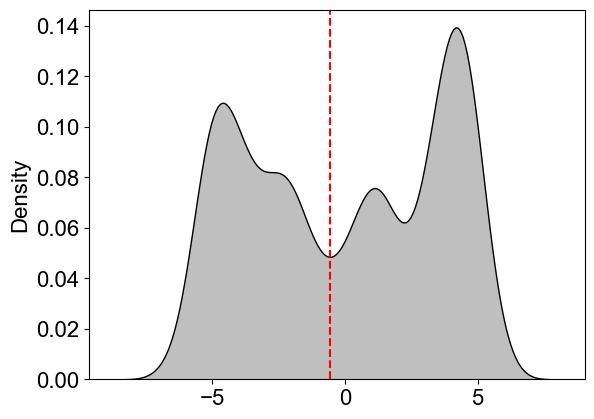

-0.24099999999999966


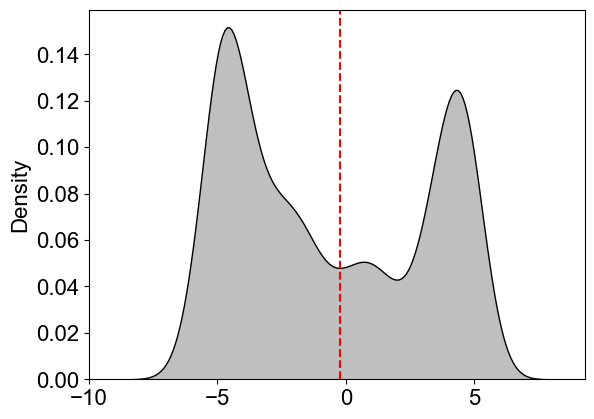

In [18]:
threshold = find_minima_in_distribution(list(df_scores_base["LBT"]),[-10,10],[-10,10],1000)
print(threshold)
sns.kdeplot(list(df_scores_base["LBT"]),color='black',fill=True)
plt.axvline(x=threshold, color='r', linestyle='--')
plt.show()
plt.close()

threshold = find_minima_in_distribution(list(df_scores_pert["LBT"]),[-10,10],[-10,10],1000)
print(threshold)
sns.kdeplot(list(df_scores_pert["LBT"]),color='black',fill=True)
plt.axvline(x=threshold, color='r', linestyle='--')
plt.show()
plt.close()

c:\users\csb_05\appdata\local\programs\python\python37\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


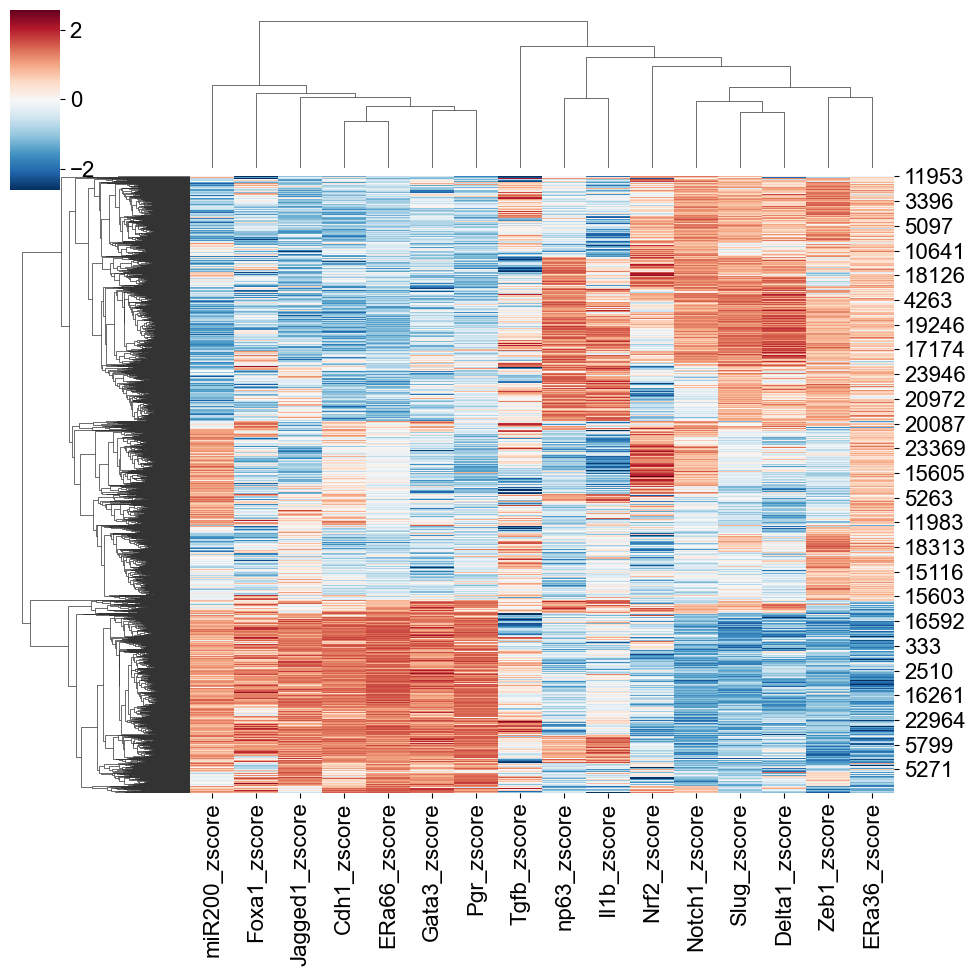

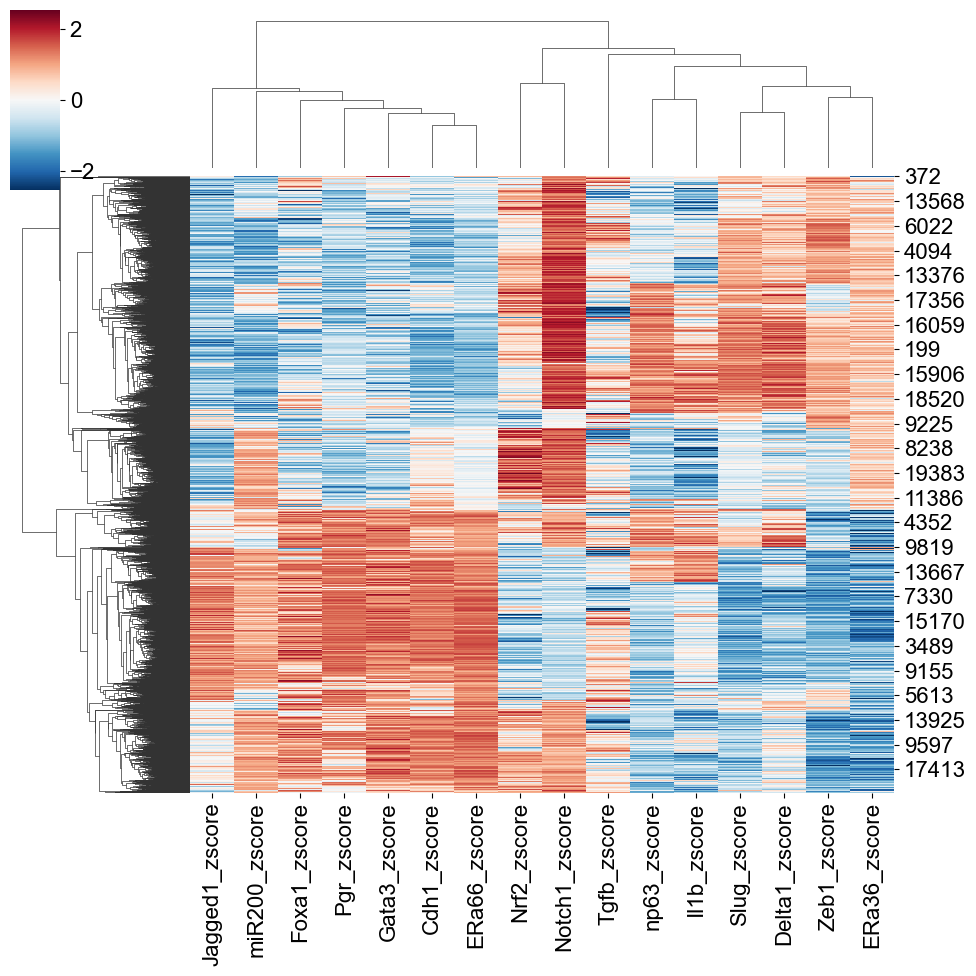

In [20]:
x1 = df_zscores_base[[i+"_zscore" for i in list_genes]]
sns.clustermap(x1.sample(n=10000),cmap="RdBu_r",vmin=-1*max(list(x1.max())))
plt.show()
plt.close()

x2 = df_zscores_pert[[i+"_zscore" for i in list_genes]]
sns.clustermap(x2.sample(n=10000),cmap="RdBu_r",vmin=-1*max(list(x2.max())))
plt.show()
plt.close()

In [22]:
df_scatter = pd.DataFrame([])
df_scatter["Epi"] = Epithelial
df_scatter["Mes"] = Mesenchymal
df_scatter["Res_score"] = Res_score
df_scatter["Lum"] = Luminal
df_scatter["Bas"] = Basal
df_scatter["pEMT"] = pEMT
df_scatter["Nrf2"] = df_zscores_base["Nrf2_zscore"]

df_scatter_pert = pd.DataFrame([])
df_scatter_pert["Epi"] = Epithelial_pert
df_scatter_pert["Mes"] = Mesenchymal_pert
df_scatter_pert["Res_score"] = Res_score_pert
df_scatter_pert["Lum"] = Luminal_pert
df_scatter_pert["Bas"] = Basal_pert
df_scatter_pert["pEMT"] = pEMT_pert
df_scatter_pert["Nrf2"] = df_zscores_pert["Nrf2_zscore"]

df_scatterbase = pd.DataFrame([])
df_scatterpert = pd.DataFrame([])

for col in list_genes:
    col_zscore = col + '_zscore'
    df_scatterbase[col_zscore] = (df_scatter[col] - df_scatter[col].mean())/df_scatter[col].std(ddof=0)

for col in list_genes:
    col_zscore = col + '_zscore'
    df_scatterpert[col_zscore] = (df_scatter_pert[col] - df_scatter[col].mean())/df_scatter[col].std(ddof=0)

sns.clustermap(df_scatterbase.sample(n=10000),cmap="RdBu_r",vmin=-1*max(list(df_scatterbase.max())))
plt.show()
plt.close()

sns.clustermap(df_scatterpert.sample(n=10000),cmap="RdBu_r",vmin=-1*max(list(df_scatterpert.max())))
plt.show()
plt.close()

KeyError: 'Slug'

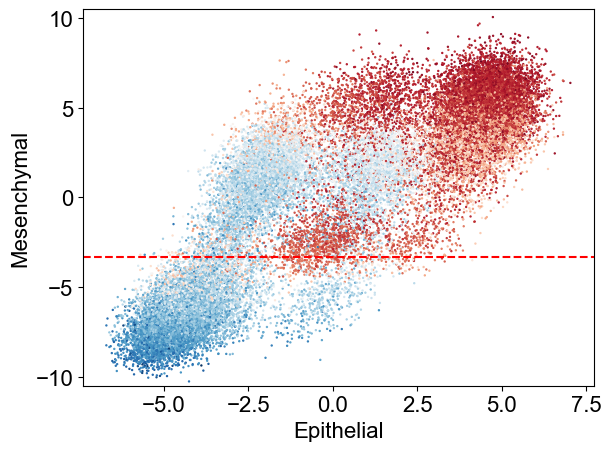

In [29]:
replicate_number = "r1"

list_genes = ['Slug','miR200','Zeb1','Cdh1','ERa66','ERa36','np63','Gata3','Foxa1','Pgr',"Nrf2"]

# base circuit
df_base = pd.read_csv("./circuit_4_WT/"+replicate_number+"/core_solution.dat", sep = "\t", header = None)
df_base.columns = ["parameter" ,"stability", "number"] + list_genes 
df_base = df_base[df_base["stability"] <= 6]


for col in list_genes:
    col_zscore = col + '_zscore'
    df_base[col_zscore] = (df_base[col] - df_base[col].mean())/df_base[col].std(ddof=0)
    

df_zscores_base = df_base[[i+"_zscore" for i in list_genes]]

df_scores_base = pd.DataFrame([])
Epithelial = df_zscores_base["miR200_zscore"] + df_zscores_base["Cdh1_zscore"]
Mesenchymal = df_zscores_base["Zeb1_zscore"] + df_zscores_base["Slug_zscore"]
EMT_score = Mesenchymal - Epithelial
Res_score = df_zscores_base["ERa36_zscore"] - df_zscores_base["ERa66_zscore"]
Luminal =  df_zscores_base["ERa66_zscore"] + df_zscores_base["Gata3_zscore"] + df_zscores_base["Foxa1_zscore"]  + df_zscores_base["Pgr_zscore"]
Basal = df_zscores_base["np63_zscore"] + df_zscores_base["Slug_zscore"]
LBT_score = Basal - Luminal
pEMT = Mesenchymal + Epithelial  - abs(EMT_score)
df_scores_base["LBT"] = LBT_score
df_scores_base["EMT"] = EMT_score
df_scores_base["Nrf2"] = df_zscores_base["Nrf2_zscore"]

lum_bas_threshold = -3.3230000000000004
df_luminal_base = df_scores_base[df_scores_base["LBT"] < lum_bas_threshold]
df_basal_base = df_scores_base[df_scores_base["LBT"] >= lum_bas_threshold]

pemt_epi_threshold = -0.6240000000000006
pemt_mes_threshold = 2.397
pemt_threshold_luminal = -1.6839999999999993

color_by = "pEMT"

plt.scatter(list(EMT_score), list(LBT_score), s = 0.5, c=Basal, cmap="RdBu_r")
#plt.scatter(list(EMT_score), list(LBT_score), s = 0.5 , c='black')
#sns.scatterplot(x=list(EMT_score), y=list(LBT_score),linewidth=0,s=3, c=df_zscores_base["Nrf2_zscore"], cmap="RdBu_r")
plt.axhline(y=lum_bas_threshold, color='r', linestyle='--')
#plt.vlines(x=pemt_epi_threshold, ymin = lum_bas_threshold, ymax = 11, color='r', linestyle='--')
#plt.vlines(x=pemt_mes_threshold, ymin = lum_bas_threshold, ymax = 11, color='r', linestyle='--')
#plt.vlines(x=pemt_threshold_luminal, ymin = -11, ymax = lum_bas_threshold, color='r', linestyle='--')
plt.ylim([-10.5,10.5])
plt.legend('',frameon=False)
plt.xlabel("Epithelial")
plt.ylabel("Mesenchymal")
plt.tight_layout()
plt.show()
plt.close()



-1.986


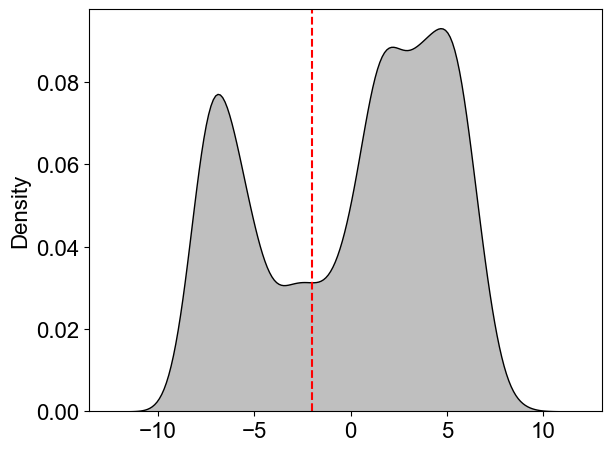

In [19]:
threshold = find_minima_in_distribution(list(LBT_score),[-10,10],[-3,10],1000)
print(threshold)
sns.kdeplot(list(LBT_score),color='black',fill=True)
plt.axvline(x=threshold, color='r', linestyle='--')
plt.tight_layout()
plt.show()
plt.close()

In [16]:
sns.kdeplot(list(EMT_score),color='black',fill=True)
plt.axvline(x=-3.1130000000000004, color='r', linestyle='--')
plt.axvline(x=-0.31499999999999995, color='r', linestyle='--')
plt.axvline(x=2.4699999999999998, color='r', linestyle='--')
plt.xlabel("EMT score")
plt.tight_layout()
plt.savefig("./plots/plots_EMT_score_WT.png", dpi=800)
plt.close()

In [22]:
sns.kdeplot(list(LBT_score),color='black',fill=True)
plt.axvline(x=-3.458, color='r', linestyle='--')
plt.axvline(x=-1.986, color='r', linestyle='--')
plt.xlabel("LBT score")
plt.tight_layout()
plt.savefig("./plots/plots_LBT_score_WT.png", dpi=800)
plt.close()

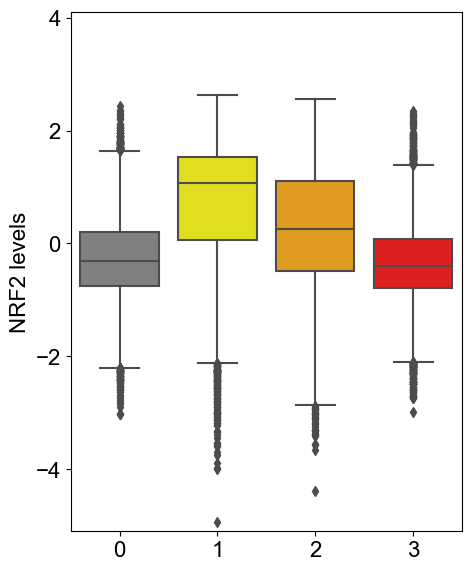

In [67]:
dfepi = df_scores_base[df_scores_base["EMT"] < -3.1130000000000004]
dfh1 = df_scores_base[(df_scores_base["EMT"] > -3.1130000000000004) & (df_scores_base["EMT"] < -0.31499999999999995)]
dfh2 = df_scores_base[(df_scores_base["EMT"] > -0.31499999999999995) & (df_scores_base["EMT"] < 2.4699999999999998)]
dfmes = df_scores_base[df_scores_base["EMT"] > 2.4699999999999998]

df_boxplot = pd.DataFrame([],columns=['Value','Label'])
for idx,g in enumerate([dfepi,dfh1,dfh2,dfmes]):
    new_df = pd.DataFrame([])
    new_df["Value"] = list(g["Nrf2"])
    new_df["Label"] = [idx]*len(g["Nrf2"])
    df_boxplot = df_boxplot.append(new_df, ignore_index=True)

plt.figure(figsize=(5, 6))
sns.boxplot(x = df_boxplot["Label"], y = df_boxplot["Value"],palette=['grey','yellow','orange','red'])
plt.xlabel("")
plt.ylabel("NRF2 levels")
plt.ylim([-5.1,4.1])
plt.tight_layout()
plt.savefig("./plots/plots_NRF2_boxplot.png", dpi=800)


c:\users\csb_05\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:1188: UserWarning: The following kwargs were not used by contour: 'scatter'
  **contour_kws,


<Figure size 600x600 with 0 Axes>

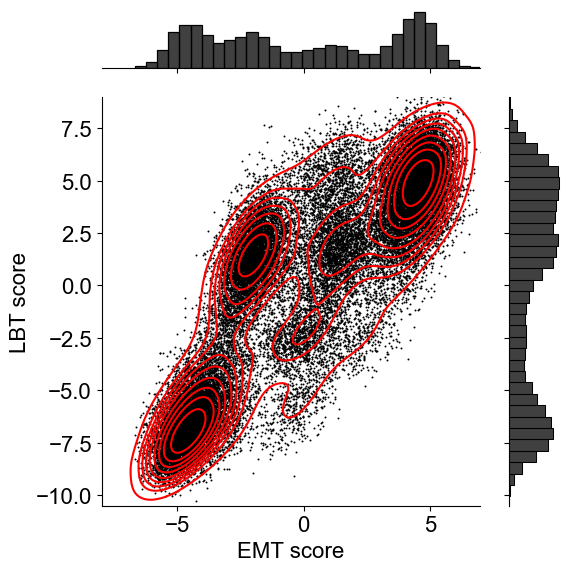

In [82]:
plt.figure(figsize=(6, 6))
#plt.scatter(list(EMT_score), list(LBT_score), s = 0.5, c=Basal, cmap="RdBu_r")
sns.jointplot(x = list(EMT_score), y = list(LBT_score), s = 2, linewidth=0 , color='black')
sns.kdeplot(x = list(EMT_score), y = list(LBT_score),scatter=False, color='red')
#sns.scatterplot(x=list(EMT_score), y=list(LBT_score),linewidth=0,s=3, c=df_zscores_base["Nrf2_zscore"], cmap="RdBu_r")
#plt.axhline(y=lum_bas_threshold, color='r', linestyle='--')
#plt.vlines(x=pemt_epi_threshold, ymin = lum_bas_threshold, ymax = 11, color='r', linestyle='--')
#plt.vlines(x=pemt_mes_threshold, ymin = lum_bas_threshold, ymax = 11, color='r', linestyle='--')
#plt.vlines(x=pemt_threshold_luminal, ymin = -11, ymax = lum_bas_threshold, color='r', linestyle='--')
plt.ylim([-10.5,9])
plt.xlim([-8,7])
plt.legend('',frameon=False)
plt.xlabel("EMT score")
plt.ylabel("LBT score")
plt.tight_layout()
plt.savefig("./plots/plots_scatter_EMT_LBT.png", dpi=800)


c:\users\csb_05\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:1188: UserWarning: The following kwargs were not used by contour: 'scatter'
  **contour_kws,


<Figure size 600x600 with 0 Axes>

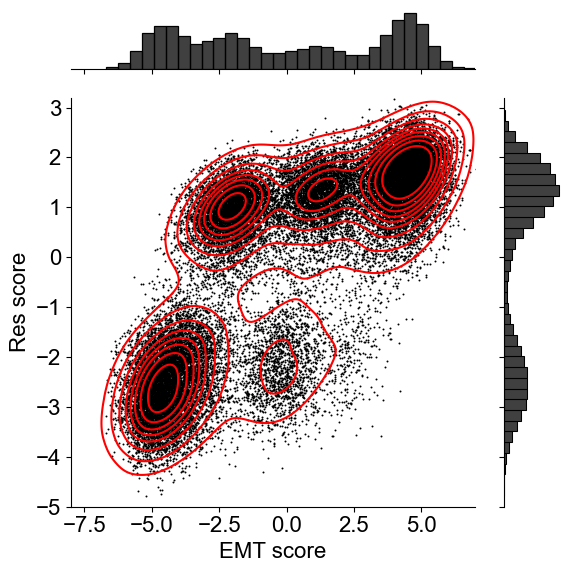

In [92]:
plt.figure(figsize=(6, 6))
#plt.scatter(list(EMT_score), list(LBT_score), s = 0.5, c=Basal, cmap="RdBu_r")
sns.jointplot(x = list(EMT_score), y = list(Res_score), s = 2, linewidth=0 , color='black')
sns.kdeplot(x = list(EMT_score), y = list(Res_score),scatter=False, color='red')
#sns.scatterplot(x=list(EMT_score), y=list(LBT_score),linewidth=0,s=3, c=df_zscores_base["Nrf2_zscore"], cmap="RdBu_r")
#plt.axhline(y=lum_bas_threshold, color='r', linestyle='--')
#plt.vlines(x=pemt_epi_threshold, ymin = lum_bas_threshold, ymax = 11, color='r', linestyle='--')
#plt.vlines(x=pemt_mes_threshold, ymin = lum_bas_threshold, ymax = 11, color='r', linestyle='--')
#plt.vlines(x=pemt_threshold_luminal, ymin = -11, ymax = lum_bas_threshold, color='r', linestyle='--')
plt.ylim([-5,3.2])
plt.xlim([-8,7])
plt.legend('',frameon=False)
plt.xlabel("EMT score")
plt.ylabel("Res score")
plt.tight_layout()
plt.savefig("./plots/plots_scatter_EMT_Res.png", dpi=800)

c:\users\csb_05\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:1188: UserWarning: The following kwargs were not used by contour: 'scatter'
  **contour_kws,


<Figure size 600x600 with 0 Axes>

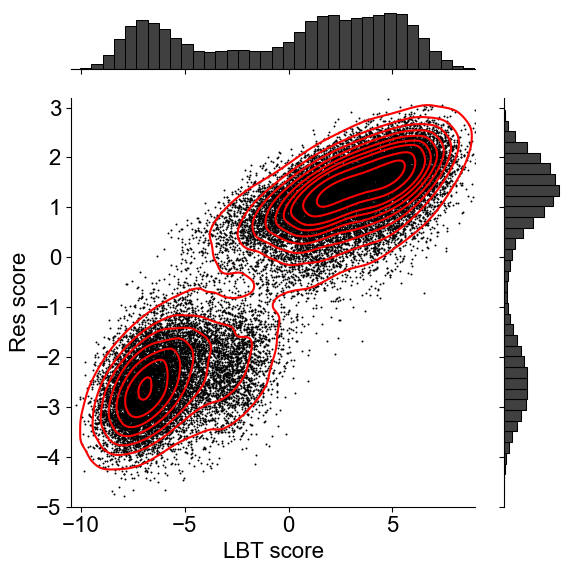

In [94]:
plt.figure(figsize=(6, 6))
#plt.scatter(list(EMT_score), list(LBT_score), s = 0.5, c=Basal, cmap="RdBu_r")
sns.jointplot(x = list(LBT_score), y = list(Res_score), s = 2, linewidth=0 , color='black')
sns.kdeplot(x = list(LBT_score), y = list(Res_score),scatter=False, color='red')
#sns.scatterplot(x=list(EMT_score), y=list(LBT_score),linewidth=0,s=3, c=df_zscores_base["Nrf2_zscore"], cmap="RdBu_r")
#plt.axhline(y=lum_bas_threshold, color='r', linestyle='--')
#plt.vlines(x=pemt_epi_threshold, ymin = lum_bas_threshold, ymax = 11, color='r', linestyle='--')
#plt.vlines(x=pemt_mes_threshold, ymin = lum_bas_threshold, ymax = 11, color='r', linestyle='--')
#plt.vlines(x=pemt_threshold_luminal, ymin = -11, ymax = lum_bas_threshold, color='r', linestyle='--')
plt.xlim([-10.5,9])
plt.ylim([-5,3.2])
plt.legend('',frameon=False)
plt.xlabel("LBT score")
plt.ylabel("Res score")
plt.tight_layout()
plt.savefig("./plots/plots_scatter_LBT_Res.png", dpi=800)

In [86]:
x1 = df_zscores_base[[i+"_zscore" for i in list_genes]]
sns.clustermap(x1.sample(n=15000),cmap="RdBu_r",vmin=-1*max(list(x1.max())))
plt.savefig("./plots/plots_clustermap_allgenes.png", dpi=800)
plt.close()

df_scatter = pd.DataFrame([])
df_scatter["Epi"] = Epithelial
df_scatter["Mes"] = Mesenchymal
df_scatter["EMT"] = Mesenchymal - Epithelial
df_scatter["Res_score"] = Res_score
df_scatter["Lum"] = Luminal
df_scatter["Bas"] = Basal
df_scatter["LBT"] = Basal - Luminal
df_scatter["pEMT"] = pEMT
df_scatter["Nrf2"] = df_zscores_base["Nrf2_zscore"]

df_scatterbase = pd.DataFrame([])

for col in ['EMT','LBT','Res_score','pEMT']:
    col_zscore = col + '_zscore'
    df_scatterbase[col_zscore] = (df_scatter[col] - df_scatter[col].mean())/df_scatter[col].std(ddof=0)

sns.clustermap(df_scatterbase.sample(n=15000),cmap="RdBu_r",vmin=-1*max(list(df_scatterbase.max())))
plt.savefig("./plots/plots_clustermap_pathways.png", dpi=800)
plt.close()


c:\users\csb_05\appdata\local\programs\python\python37\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


c:\users\csb_05\appdata\local\programs\python\python37\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


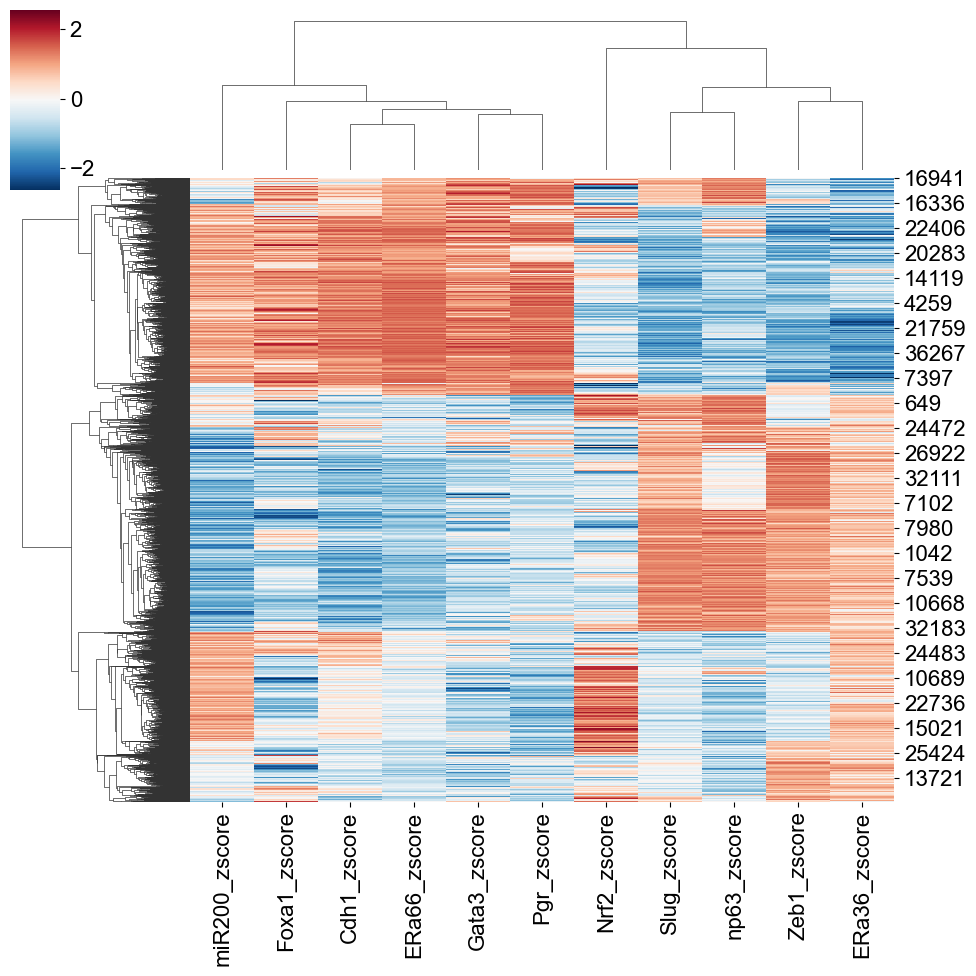

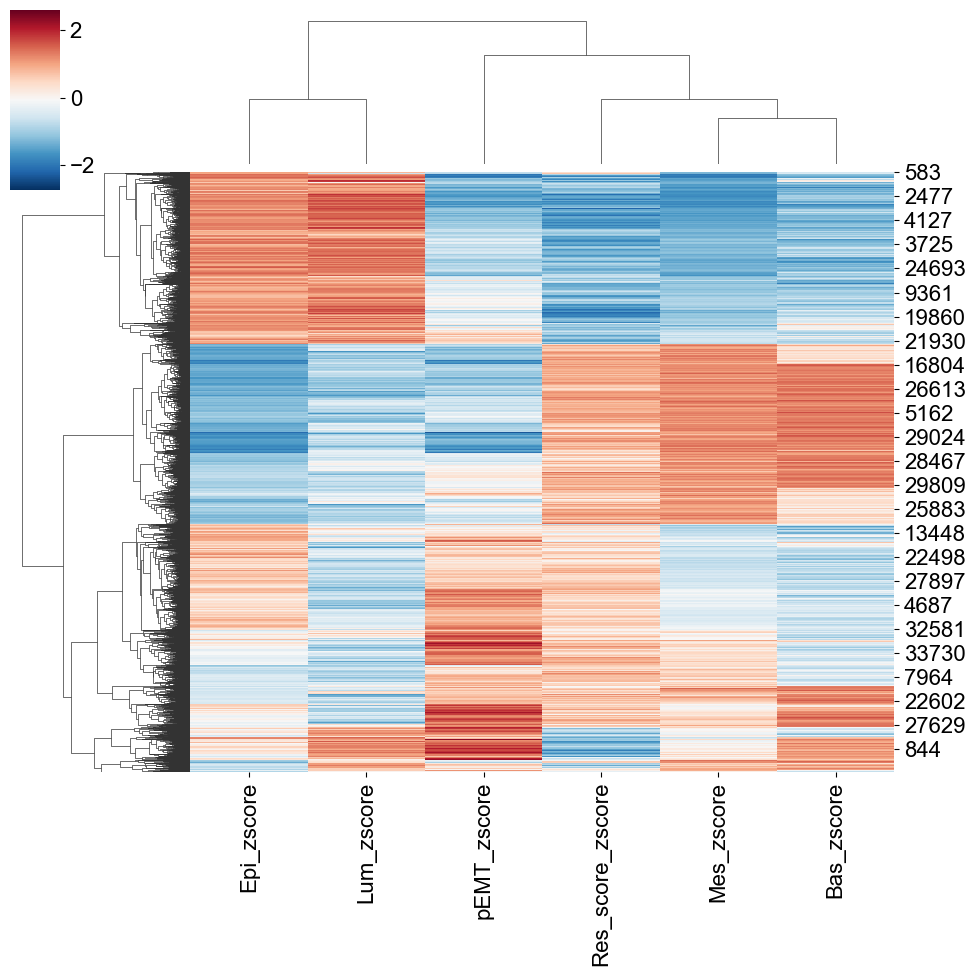

In [40]:
x1 = df_zscores_base[[i+"_zscore" for i in list_genes]]
sns.clustermap(x1.sample(n=10000),cmap="RdBu_r",vmin=-1*max(list(x1.max())))
plt.show()
plt.close()

df_scatter = pd.DataFrame([])
df_scatter["Epi"] = Epithelial
df_scatter["Mes"] = Mesenchymal
df_scatter["Res_score"] = Res_score
df_scatter["Lum"] = Luminal
df_scatter["Bas"] = Basal
df_scatter["pEMT"] = pEMT
df_scatter["Nrf2"] = df_zscores_base["Nrf2_zscore"]

df_scatterbase = pd.DataFrame([])

for col in ['Epi','Mes','Lum','Bas','Res_score','pEMT']:
    col_zscore = col + '_zscore'
    df_scatterbase[col_zscore] = (df_scatter[col] - df_scatter[col].mean())/df_scatter[col].std(ddof=0)

sns.clustermap(df_scatterbase.sample(n=10000),cmap="RdBu_r",vmin=-1*max(list(df_scatterbase.max())))
plt.show()
plt.close()

